In [2]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol as sobol_analyze
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import pickle
from joblib import Parallel, delayed
from SALib.sample import sobol
from SALib.sample import saltelli
from IPython.display import clear_output
import numpy as np
from itertools import product
import time
import random


from model import SugarscapeG1mt

### RUNNING FOR BASE SETTINGS - NO TAX, NO STAGHUNT

In [2]:
cont_vars = [
    "initial_population",
    "metabolism_min",
    "metabolism_max",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    # "metabolism_min",
    # "metabolism_max",
]
# cont_bounds = [
#     [50, 500],
#     [0.1, 2.0],
#     [2.0, 3],
#     [0, 10],
#     [15, 30],
#     [1.0, 5.0],
#     [5.0, 10.0],
#     [0, 10],
#     [15, 30],
# ]

adjusted_bounds = [
    [25, 250], # initial population
    [0.1, 1.0],  # metabolism min
    [1.1, 2.0], # metabolism max
    [0, 5], # endowmnent min
    [8, 20], #endownment max
    [1.0, 3.0], # vision min
    [3.1, 6.0], # vision max
]
problem = {
    "num_vars": len(cont_vars),
    "names": cont_vars,
    "bounds": adjusted_bounds,
}

# ----------------------------------------------------------------------
# Integer variables that need rounding
# ----------------------------------------------------------------------
integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
}

# ----------------------------------------------------------------------
# Fixed discrete factors – only one option each
# ----------------------------------------------------------------------
discrete_factors = {
    "wealth_tax_system": [0],   # 0 ≙ "none"
    "income_tax_system": [0],   # 0 ≙ "none"
    "enable_staghunt":   [0],   # OFF
}

wealth_tax_map  = {0: "none", 1: "proportional", 2: "progressive", 3: "degressive"}
income_tax_map  = wealth_tax_map.copy()


In [4]:
# ----------------------------------------------------------------------
# GSA settings
# ----------------------------------------------------------------------
replicates       = 10        # Replicates should be at least 10
max_steps        = 100      # Max steps per run should be at least 100
distinct_SA      = 512         # N should be 512
second_order     = False    # Set false for our analysis.
measure          = "Gini"       # can switch to "Avg Wealth"

In [4]:
def run_mixed(run_id, params):
    # 1 – round integers
    for name in integer_vars:
        if name in params:
            params[name] = int(round(params[name]))

    # 2 – enforce ordering on min/max pairs
    for lo, hi, caster in [
        ("endowment_min", "endowment_max", int),
        ("vision_min",    "vision_max",    int),
        ("metabolism_min","metabolism_max",float),
    ]:
        lo_val, hi_val = sorted((params[lo], params[hi]))
        params[lo], params[hi] = caster(lo_val), caster(hi_val)

    # 3 – disable staghunt parameters
    params["enable_staghunt"] = False
    params["p_copy"]  = 0.0
    params["p_mutate"] = 0.0

    # 4 – map tax codes to strings (both are “none”)
    params["wealth_tax_system"]  = wealth_tax_map[0]
    params["income_tax_system"]  = income_tax_map[0]

    # 5 – cast remaining floats
    params["flat_rate"]           = float(params.get("flat_rate", 0.0))
    params["income_tax_flat_rate"]= float(params.get("income_tax_flat_rate", 0.0))

    # 6 – run the model
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False,
    )[0]

    return {
        **params,
        "RunId": run_id,
        "Gini": out["Gini"],
        "Avg Wealth": out["Average Wealth"],
    }

def run_mixed_safe(run_id, rep, params):
    seed = 1 + run_id + rep * 10000
    random.seed(seed)
    np.random.seed(seed)
    return run_mixed(run_id, params)

In [5]:
all_records = []

# Sample the continuous space once
X = sobol.sample(problem, distinct_SA, calc_second_order=second_order)

tasks = []
for run_id, cont_vals in enumerate(X):
    base = dict(zip(problem["names"], cont_vals))

    # inject fixed discrete settings
    base.update({
        "wealth_tax_system": 0,
        "income_tax_system": 0,
        "enable_staghunt":  False,
    })

    for rep in range(replicates):
        tasks.append((run_id, rep, base.copy()))

# parallel evaluation
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_mixed_safe)(rid, rep, p) for rid, rep, p in tasks
)

record = {
    "discrete_setting": (0, 0, False),
    "samples": X,
    "results": results,
}
all_records.append(record)

with open("sobol_none_tax_no_staghunt_FINAL.pkl", "wb") as f:
    pickle.dump(record, f)

print(f"Saved sobol_none_tax_no_staghunt_FINAL.pkl with {len(results)} runs")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   42.8s
c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:78

Saved sobol_none_tax_no_staghunt_FINAL.pkl with 46080 runs


c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                          ST   ST_conf
initial_population  0.044572  0.003666
metabolism_min      0.128179  0.016549
metabolism_max      0.126179  0.016603
endowment_min       0.226565  0.022683
endowment_max       0.220402  0.022403
vision_min          0.293004  0.029245
vision_max          0.298225  0.028572
                          S1   S1_conf
initial_population  0.002625  0.010429
metabolism_min      0.031548  0.021298
metabolism_max      0.020143  0.020720
endowment_min       0.081472  0.024749
endowment_max       0.078097  0.024802
vision_min          0.158871  0.026466
vision_max          0.161093  0.026543
                                            S2   S2_conf
(initial_population, metabolism_min)  0.205124  0.029537
(initial_population, metabolism_max)  0.207368  0.028279
(initial_population, endowment_min)   0.240429  0.028036
(initial_population, endowment_max)   0.240641  0.029091
(initial_population, vision_min)      0.241632  0.028278
(initial_population, vision_max)  

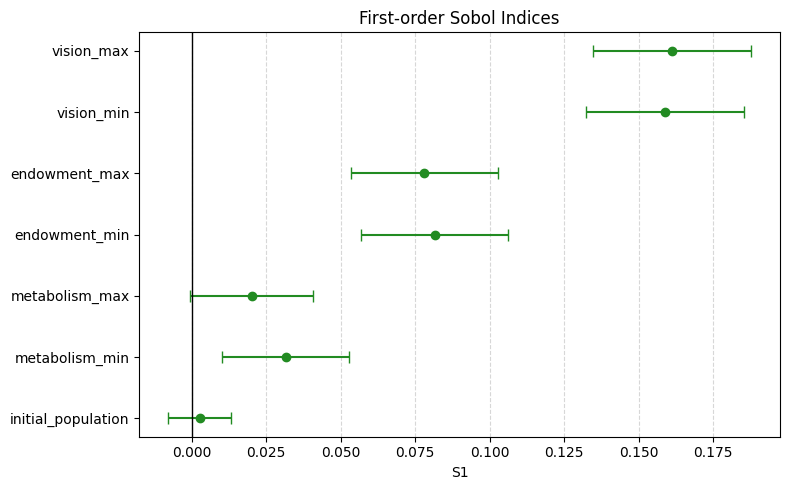

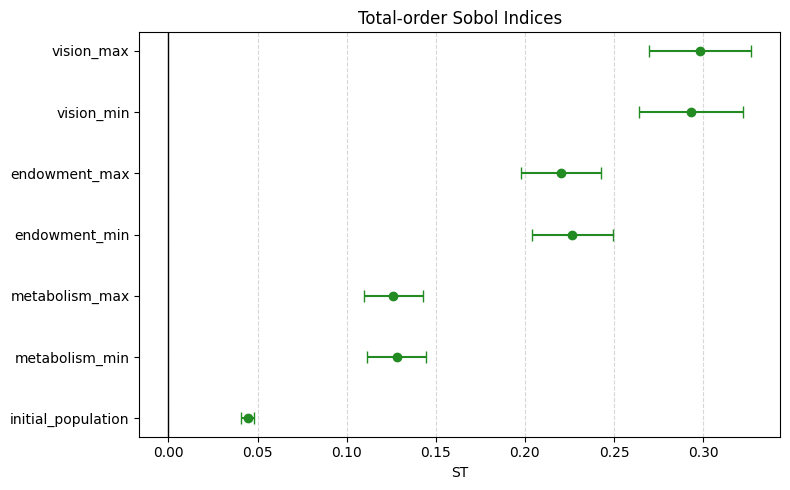

In [6]:
with open("sobol_none_tax_no_staghunt_FINAL.pkl", "rb") as f:
    record = pickle.load(f)

# Unpack inputs
X = record["samples"]
results = record["results"]

# Calculate expected dimensions first
n_samples = len(X)
n_replicates = len(results) // n_samples

# Aggregate results by taking mean across replicates for each sample
Y_all = np.array([r["Gini"] for r in results])

# Reshape and take mean across replicates
Y = Y_all.reshape(n_samples, n_replicates).mean(axis=1)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Si = sobol_analyze.analyze(
    problem,
    Y, 
    calc_second_order=True,
    print_to_console=True
)

# Plot Sobol indices with error bars
def plot_sobol_indices(Si, index_type='S1', title='Sobol Sensitivity Indices'):
    indices = Si[index_type]
    errors = Si[index_type + '_conf']
    labels = problem['names']

    x = np.arange(len(indices))
    plt.figure(figsize=(10, 5))
    plt.bar(x, indices, yerr=errors, align='center', alpha=0.7, capsize=5)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel(index_type)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_sobol_indices_horizontal(Si, index_type='S1', title='First order sensitivity'):
    indices = Si[index_type]
    errors = Si[index_type + '_conf']
    labels = problem['names']

    y = np.arange(len(indices))

    plt.figure(figsize=(8, 5))
    plt.errorbar(indices, y, xerr=errors, fmt='o', color='forestgreen', ecolor='forestgreen', capsize=4)
    plt.axvline(x=0.0, color='black', linewidth=1)
    
    plt.yticks(y, labels)
    plt.xlabel(index_type)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
# First-order (S1)
plot_sobol_indices_horizontal(Si, 'S1', title='First-order Sobol Indices')

# Total-order (ST)
plot_sobol_indices_horizontal(Si, 'ST', title='Total-order Sobol Indices')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
max_steps = 200
n = 20

def run_model(params, seed=None):
    """Run the SugarscapeG1mt model with given parameters and return Gini coefficient"""
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Process parameters like in the main analysis
    processed_params = params.copy()
    
    # 1 – round integers
    for name in integer_vars:
        if name in processed_params:
            processed_params[name] = int(round(processed_params[name]))

    # 2 – enforce ordering on min/max pairs
    for lo, hi, caster in [
        ("endowment_min", "endowment_max", int),
        ("vision_min",    "vision_max",    int),
        ("metabolism_min","metabolism_max",float),
    ]:
        if lo in processed_params and hi in processed_params:
            lo_val, hi_val = sorted((processed_params[lo], processed_params[hi]))
            processed_params[lo], processed_params[hi] = caster(lo_val), caster(hi_val)

    # 3 – disable staghunt parameters
    processed_params["enable_staghunt"] = False
    processed_params["p_copy"]  = 0.0
    processed_params["p_mutate"] = 0.0

    # 4 – map tax codes to strings (both are "none")
    processed_params["wealth_tax_system"]  = "none"
    processed_params["income_tax_system"]  = "none"

    # 5 – cast remaining floats
    processed_params["flat_rate"]           = 0.0
    processed_params["income_tax_flat_rate"]= 0.0

    # 6 – run the model
    try:
        out = batch_run(
            SugarscapeG1mt,
            parameters=processed_params,
            iterations=1,
            max_steps=max_steps,
            data_collection_period=-1,
            display_progress=False,
        )[0]
        
        return out["Gini"]
    except Exception as e:
        print(f"Error running model with params {processed_params}: {e}")
        return np.nan

# -------------------------
# OFAT Analysis
# -------------------------

print("=== ONE FACTOR AT A TIME (OFAT) ANALYSIS ===")

# Baseline values = midpoint of each bound
baseline = {
    name: np.mean(bound) for name, bound in zip(problem["names"], problem["bounds"])
}

# Include discrete factors as fixed
baseline.update({k: v[0] for k, v in discrete_factors.items()})

print("Baseline parameter values:")
for param, value in baseline.items():
    if param in problem["names"]:
        print(f"  {param}: {value:.3f}")

print(f"\nEach parameter will be varied across 10 steps while others remain at baseline")
print(f"Replications per parameter value: {n}")
print(f"Model runs per parameter: 10 x {n} = {10 * n}")
print(f"Total model runs: {len(problem['names']) * 10 * n}")

# Prepare for results storage
results = {var: {"x": [], "y_mean": [], "y_std": [], "y_all": []} for var in problem["names"]}

# Loop over each continuous variable
print("Running OFAT Analysis...")
for i, var in enumerate(problem["names"]):
    print(f"Analyzing variable {i+1}/{len(problem['names'])}: {var}")
    var_min, var_max = problem["bounds"][i]
    # Choose N steps between min and max
    N = 10
    x_values = np.linspace(var_min, var_max, N)

    y_values = []

    for j, x in enumerate(x_values):
        # Set baseline values
        params = baseline.copy()
        # Vary one variable
        params[var] = round(x) if var in integer_vars else x

        # Run model n times with different seeds and collect all results
        y_replicates = []
        for rep in range(n):
            seed = 1000 * i + 100 * j + rep  # Unique seed for each run
            output = run_model(params, seed=seed)
            y_replicates.append(output)
        
        # Calculate statistics
        y_replicates = np.array(y_replicates)
        mean_gini = np.nanmean(y_replicates)
        std_gini = np.nanstd(y_replicates)
        
        # Store results
        results[var]["y_mean"].append(mean_gini)
        results[var]["y_std"].append(std_gini)
        results[var]["y_all"].append(y_replicates)
        
        # Progress indicator
        if (j + 1) % 5 == 0 or j == len(x_values) - 1:
            print(f"  Step {j+1}/{N} completed (mean Gini: {mean_gini:.3f} ± {std_gini:.3f})")

    # Store x values
    results[var]["x"] = x_values

print("OFAT Analysis completed!")


# -------------------------
# Plotting results with error bars
# -------------------------

fig, axs = plt.subplots(len(problem["names"]), 1, figsize=(10, 4 * len(problem["names"])))

if len(problem["names"]) == 1:
    axs = [axs]  # Ensure axs is iterable

for ax, var in zip(axs, problem["names"]):
    x_vals = results[var]["x"]
    y_means = results[var]["y_mean"]
    y_stds = results[var]["y_std"]
    
    # Plot mean with error bars (standard deviation)
    ax.errorbar(x_vals, y_means, yerr=y_stds, marker="o", linewidth=2, markersize=6, 
                capsize=4, capthick=1, elinewidth=1, alpha=0.8)
    
    # Also plot individual points as semi-transparent dots
    for i, (x_val, y_reps) in enumerate(zip(x_vals, results[var]["y_all"])):
        ax.scatter([x_val] * len(y_reps), y_reps, alpha=0.3, s=10, color='gray')
    
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel("Gini Coefficient", fontsize=12)
    ax.set_title(f"OFAT: {var} vs Gini Coefficient (n={n} replications)", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add some styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add text box with statistics
    y_range = np.max(y_means) - np.min(y_means)
    max_std = np.max(y_stds)
    info_text = f"Range: {y_range:.3f}\nMax StdDev: {max_std:.3f}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== OFAT SUMMARY STATISTICS ===")
for var in problem["names"]:
    y_means = np.array(results[var]["y_mean"])
    y_range = np.max(y_means) - np.min(y_means)
    avg_std = np.mean(results[var]["y_std"])
    print(f"{var:15s}: Range = {y_range:.4f}, Avg StdDev = {avg_std:.4f}")


=== ONE FACTOR AT A TIME (OFAT) ANALYSIS ===


NameError: name 'problem' is not defined